# Option 1: Sentiment Identification

Name : Mohan Rao B C            
email: mohanraobc@gmail.com

###### BACKGROUND
A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks
about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist for
sentiment analysis, however, they need help with under-resourced languages.

###### GOAL
Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to
maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data
includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled. Please describe the business outcomes in your work sample including how data limitations impact your results
and how these limitations could be addressed in a larger project.

### Initial Thoughts
1. Though the input data is in english text but the language is urdu and roman mixed form
2. The most used library dealing with text data is NLTK but the library is mostly optimized for english language
3. Some of the typical operations like stemming would not be possible for the current data
4. Having said that, the classifier models wont have an impact as they work on pieces of strings and language should not matter

The problem at hand is a supervised multiclass classification learning problem. As the data is in text form, we could try few algorithms which are known to work well in such settings

In [1]:
# Importing the requisite libraries
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Setting up the working directories

inp_path = "C:/Users/mohan/Desktop/Amazon_case/input/"
out_path = "C:/Users/mohan/Desktop/Amazon_case/output/"

In [3]:
# Reading the input data

colnames=['text', 'sentiment'] 
df = pd.read_csv(inp_path + "Roman Urdu DataSet.csv", index_col = False, header = None, names=colnames)

In [4]:
#checking the dataframes
df.head()

,text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


In [5]:
# Exploring the data
df.describe()


,text,sentiment
count,20228,20229
unique,19664,4
top,Good,Neutral
freq,23,8929


In [6]:
# Checking the number of categories for sentiment in the tranining data
category_counter={x:0 for x in set(df['sentiment'])}
for each_cat in df['sentiment']:
    category_counter[each_cat]+=1

print(category_counter)

{'Positive': 6013, 'Negative': 5286, 'Neutral': 8929, 'Neative': 1}


In [7]:
# Fairly balanced observations for each category of sentiment
# observe a typo in the category - 'Neative' - should be 'Negetive' - Lets correct this
df['sentiment'] = df['sentiment'].replace('Neative','Negative' )

# Checking the number of categories for sentiment in the tranining data
category_counter={x:0 for x in set(df['sentiment'])}
for each_cat in df['sentiment']:
    category_counter[each_cat]+=1

print(category_counter)

{'Positive': 6013, 'Negative': 5287, 'Neutral': 8929}


In [8]:
# Checking for missing values in the text and sentiment column

# creating bool series True for NaN values  
bool_series = pd.isnull(df["text"])

df[bool_series]  

,text,sentiment
16904,NaN,Neutral


In [9]:
# One entry is blank in the review text
# We know we have no blanks in setiment column
# We are in luck, we need to eliminate only on observation due to missing data
# Lets remove this observation

bool_series = pd.notnull(df["text"])

df1 = df[bool_series]

print(df1.describe())

df1.head()


         text sentiment
count   20228     20228
unique  19664         3
top      Good   Neutral
freq       23      8928


,text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


In [10]:
# It is generally good idea to check the length of the text reviews
# lets check the examples of one word and two word reviews and see if they adds value to model or we can ignore them

docs = df1['text'].tolist()
# initiating an empty list to get the length of the review in terms of number of words
frequency = []

# for loop to get the list of review lengths in terms of number of words
for docs in docs:
    x=docs.split(None)
    f= len(x)
    frequency.append(f)

# adding the review lengths in terms of number of words to the initial dataframe
    
se=pd.Series(frequency)
df1['review_length'] = se.values

df1.head()

C:\Users\mohan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text,sentiment,review_length
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,25
1,sahi bt h,Positive,3
2,"Kya bt hai,",Positive,3
3,Wah je wah,Positive,3
4,Are wha kaya bat hai,Positive,5


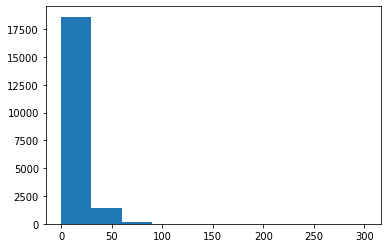

In [11]:
# Checking the distribution of the review_length

plt.hist(df1['review_length'], bins = 10)
plt.show()

In [12]:
# The histogram looks odd - Looks like thre are reviews that are more than 250 words length
# Checking max and min of review length
print(df1['review_length'].max())
print(df1['review_length'].min())

301
0


In [13]:
#Lets check all the reviews that are more tha 100 words long

df_100 = df1[df1.review_length >= 100]
print(df_100)

                                                    text sentiment  \
1022   Gumshoda aur agwa shoda ashkhas ki bazyabi key...  Positive   
1024   Insani haqooq key leyeh Ansar Burney ki khidma...  Positive   
1028   Yon to Asma jahangir ki puri zindagi hi amriaa...  Positive   
1231    App Shaheed huye to app ki jaib se 100 ruppey...  Positive   
1267    Yahen un ke han 12 December 1948 ko dosra bac...  Positive   
1616   Meine yehee Maximus ki HID do baar pehlay khar...  Positive   
2116   Abdul wali bro nice job yar ap bhoot acha kam ...  Positive   
2136   Phone tou no doubt bohat smart hai, looks mein...  Positive   
2524   To kiya deegar hum asar actors ki zati zindagi...  Positive   
2527   Jo shaks zindagi ki sari kamyaban moqadder mei...  Positive   
2528   Waheed Murad key walid Nisar Murad Karachi mei...  Positive   
2774   Mohammad Hafeez: Meri ray ke mutabiq kheelon k...  Positive   
2788   Mohammad Hafeez: Main aur Misbah 14 baras se a...  Positive   
3149   Sb sy pehly t

In [14]:
# The longer reviews looks legit - so Lets move on to data prep for building models


In [15]:
#Creating a corpus of the review text for initializing TF-IDF vectorizer
corpus=df1.text
corpus.head()

0    Sai kha ya her kisi kay bus ki bat nhi hai lak...
1                                            sahi bt h
2                                          Kya bt hai,
3                                           Wah je wah
4                                 Are wha kaya bat hai
Name: text, dtype: object

In [16]:
#Initializing TFIDF vectorizer to convert the raw corpus to a matrix of TFIDF features
no_features = 20000
vectorizer = TfidfVectorizer(max_df=0.70, min_df=0.0001, max_features=no_features,ngram_range=(1,3))

In [17]:
#creating TFIDF features sparse matrix by fitting it on the specified corpus
tfidf_matrix=vectorizer.fit_transform(corpus).todense()
#grabbing the name of the features.
tfidf_names=vectorizer.get_feature_names()

print("Number of TFIDF Features: %d"%len(tfidf_names)) #same info can be gathered by using tfidf_matrix.shape
tfidf_matrix.shape

Number of TFIDF Features: 20000


(20228, 20000)

In [18]:
# Splitting the input data into Training, Test and Validation datasets in the ration 60% 20% and 20% respectively

#considering the TFIDF features as independent variables to be input to the classifier

variables = tfidf_matrix

#considering the category values as the class labels for the classifier.

labels = df1.sentiment

#splitting the data into random training, test and validation sets for both independent variables and labels.

variables_train, variables_test, labels_train, labels_test  =   train_test_split(variables, labels, test_size=0.2, random_state=1)

variables_train, variables_val, labels_train, labels_val = train_test_split(variables_train, labels_train, test_size=0.25, random_state=1)



In [19]:
#analyzing the shape of the training, test and validation data-set:
print('Shape of Training Data: '+str(variables_train.shape))
print('Shape of Validation Data: '+str(variables_val.shape))
print('Shape of Test Data: '+str(variables_test.shape))

Shape of Training Data: (12136, 20000)
Shape of Validation Data: (4046, 20000)
Shape of Test Data: (4046, 20000)


# Let the Machine start learning
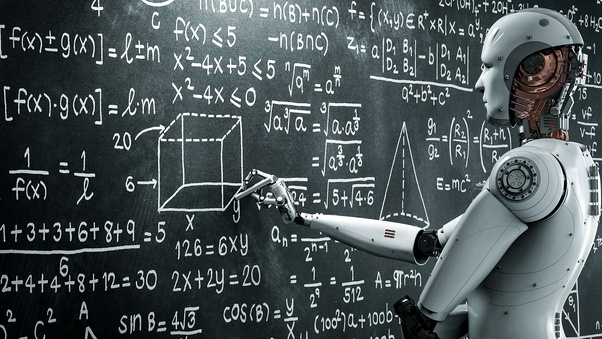

In [20]:
#Function for Plotting Confusion Matrix - Source - https://www.kaggle.com/agungor2/various-confusion-matrix-plots

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sn.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

Accuracy Score of Logistic Regression Classifier: 0.635195


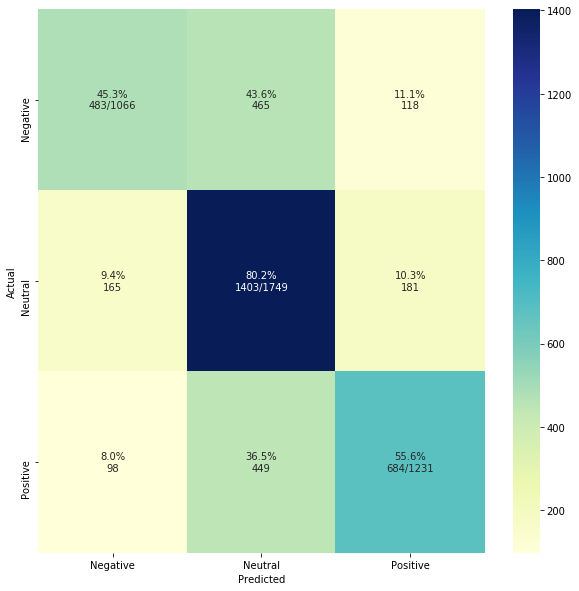

In [21]:
# First try - Logistic Regression Clasifier

#initializing the object
Logreg_classifier= LogisticRegression(penalty='l2', solver='newton-cg', random_state=0, multi_class='multinomial')

#fitting the classifier or training the classifier on the training data
Logreg_classifier=Logreg_classifier.fit(variables_train, labels_train)

#after the model has been trained, we proceed to test its performance on the test data
Logreg_predictions=Logreg_classifier.predict(variables_test)

#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:

Logreg_ascore=sklearn.metrics.accuracy_score(labels_test, Logreg_predictions)

print ("Accuracy Score of Logistic Regression Classifier: %f" %(Logreg_ascore))

plot_cm(labels_test, Logreg_predictions)

Bernoulli Naive Bayes Accuracy Score:  0.590707


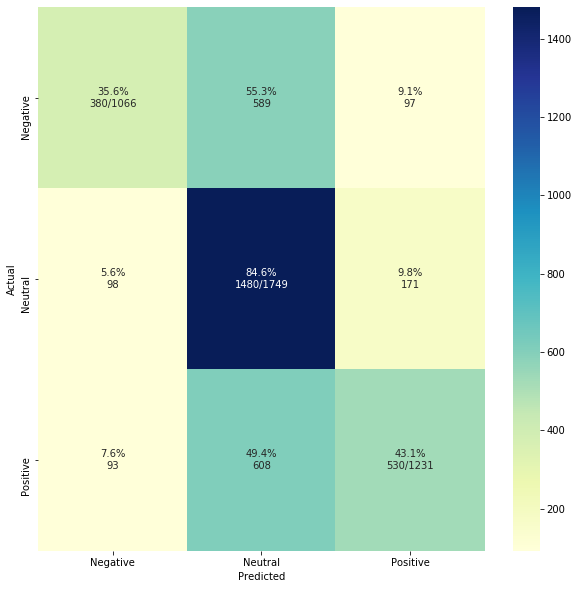

In [22]:
# Second try - Naive Bayes Classifier

#initializing the object

bnb_classifier=BernoulliNB()

#fitting the classifier or training the classifier on the training data
bnb_classifier=bnb_classifier.fit(variables_train,labels_train)

#after the model has been trained, we proceed to test its performance on the test data
bnb_predictions=bnb_classifier.predict(variables_test)

#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:
nb_ascore=sklearn.metrics.accuracy_score(labels_test, bnb_predictions)

print("Bernoulli Naive Bayes Accuracy Score:  %f" %(nb_ascore))

plot_cm (labels_test, bnb_predictions)

Accuracy Score of Multi-Nomial Naive Bayes: 0.607019


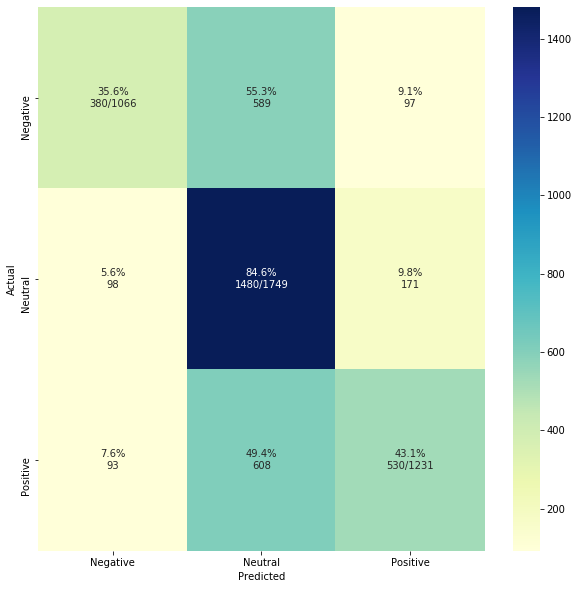

In [23]:
# Third try - Multinomial Naive Bayes Classifier

#initializing the object
mn_bayes=MultinomialNB()

#fitting the classifier or training the classifier on the training data
mn_bayes_fit=mn_bayes.fit(variables_train,labels_train)

#after the model has been trained, we proceed to test its performance on the test data
prediction_mn=mn_bayes_fit.predict(variables_test)

#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:
mn_ascore=sklearn.metrics.accuracy_score(labels_test, prediction_mn) 

print("Accuracy Score of Multi-Nomial Naive Bayes: %f" %(mn_ascore))

plot_cm (labels_test, bnb_predictions)

In [24]:
# Fourth try - Random Forest Classifier

#initializing the object
rf_classifier=RandomForestClassifier(n_estimators=200)

#fitting the classifier or training the classifier on the training data
rf_classifier=rf_classifier.fit(variables_train,labels_train)

#after the model has been trained, we proceed to test its performance on the test data
rf_predictions=rf_classifier.predict(variables_test)

#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:
rf_ascore=sklearn.metrics.accuracy_score(labels_test, rf_predictions)

print ("Accuracy Score of Random Forests Classifier: %f" %(rf_ascore))


Accuracy Score of Random Forests Classifier: 0.600099


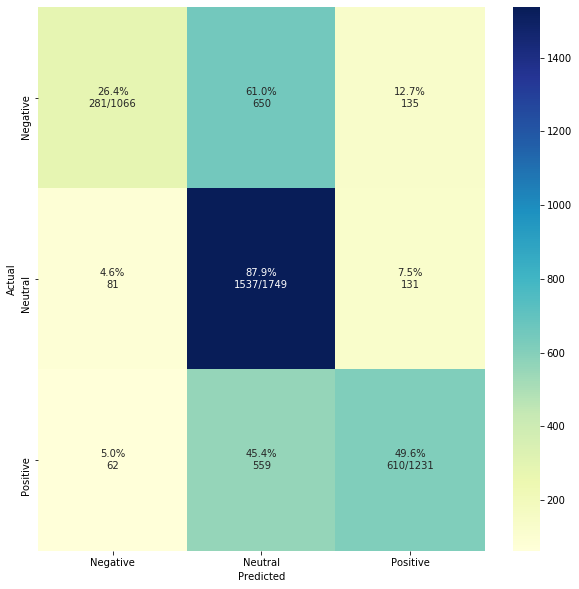

In [25]:
plot_cm (labels_test, rf_predictions)

Accuracy Score of Linear SVM Classifier: 0.616906


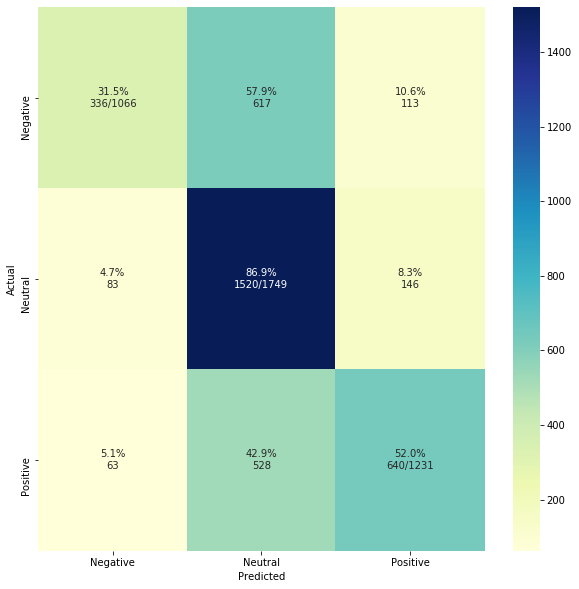

In [26]:
# Fifth try - Linear Classifier (SVM) using Stochastic Gradient Descent

#initializing the object
svm_classifier=linear_model.SGDClassifier(loss="log",penalty="l2", alpha=0.0001)

#fitting the classifier or training the classifier on the training data
svm_classifier=svm_classifier.fit(variables_train, labels_train)

#after the model has been trained, we proceed to test its performance on the test data
svm_predictions=svm_classifier.predict(variables_test)

#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:

svm_ascore=sklearn.metrics.accuracy_score(labels_test, svm_predictions)

print ("Accuracy Score of Linear SVM Classifier: %f" %(svm_ascore))

plot_cm (labels_test, svm_predictions)

Accuracy Score of Ensemble Classifier: 0.630994


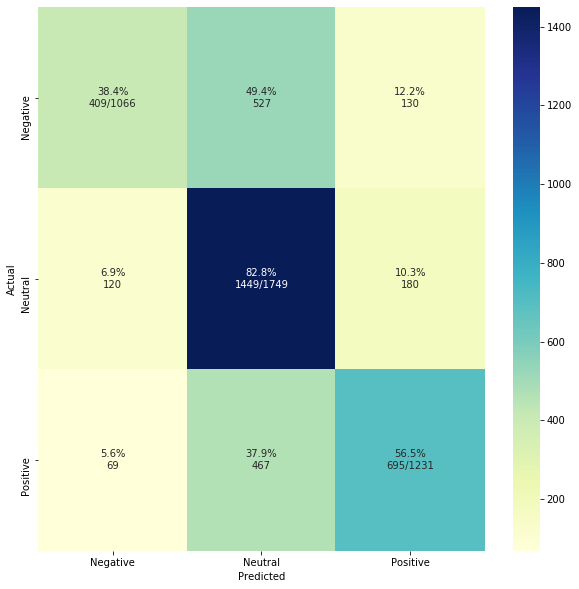

In [27]:
# Sixth try - Picking up the models that have shown highest accuracy for ensembling

ensemble_classifier = VotingClassifier(estimators=[('LR',Logreg_classifier),('MNB',mn_bayes), ('SVML',svm_classifier)],
                        voting='soft',
                        weights=[4,1,2])

#fitting the classifier or training the classifier on the training data
ensemble_classifier = ensemble_classifier.fit(variables_train, labels_train)

#after the model has been trained, we proceed to test its performance on the test data
ensemble_predictions = ensemble_classifier.predict(variables_test)

#the trained classifier has been used to make predictions on the test data-set. To evaluate the performance of the model,
#there are a number of metrics that can be used as follows:

ensemble_ascore=sklearn.metrics.accuracy_score(labels_test, ensemble_predictions)

print ("Accuracy Score of Ensemble Classifier: %f" %(ensemble_ascore))

plot_cm (labels_test, ensemble_predictions)

The ensemble model is performing marginally better than individual model and the most accurate of the lot is multinomial logistic regression

The next option is to try deeplearning models - RNN with LSTM seems promising based on few papers online

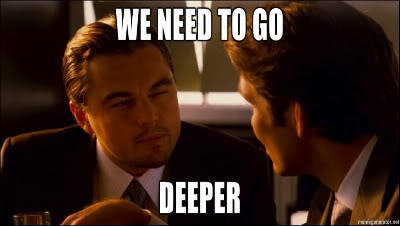

In [28]:
# Importing Necessary Libraries

import tensorflow as tf 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [29]:
# Convert Cuisines to integers as most of the machine learning models deal with integer or float
df1['sentiment'] = df1.sentiment.astype('category').cat.codes

C:\Users\mohan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
df1.head()

,text,sentiment,review_length
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,2,25
1,sahi bt h,2,3
2,"Kya bt hai,",2,3
3,Wah je wah,2,3
4,Are wha kaya bat hai,2,5


In [31]:
# For a deep learning model we need to know what the input sequence length for our model should be
# Calculate the number of words in the ingredients column and find the maximum value to be used for input sequence

df1['num_words'] = df1.text.apply(lambda x : len(x.split()))

df1['num_words'].max()

C:\Users\mohan\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


301

In [32]:
# Set number of classes and target variable
num_class = len(np.unique(df1.sentiment.values))
y = df1['sentiment'].values

In [33]:
#Tokenize the input and pad
MAX_LENGTH = 302
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df1.text.values)
post_seq = tokenizer.texts_to_sequences(df1.text.values)
post_seq_padded = tf.keras.preprocessing.sequence.pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [34]:
vocab_size = len(tokenizer.word_index) + 1

In [35]:
# Creating a train test split with 30% in testing data set
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.20)

In [36]:
# Deep Learning Model : Simple
# Let start with a simple model where the build an embedded layer, Dense followed by our prediction

inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size, 200, input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dense(64, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.20, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 302)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 302, 200)          6658600   
_________________________________________________________________
flatten (Flatten)            (None, 60400)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3865664   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 10,524,459
Trainable params: 10,524,459
Non-trainable params: 0
_________________________________________________________________
Train on 12945 samples, validate on 3237 samples
Epoch 1/5
12928/12945 [============================>.] - ETA: 0s -

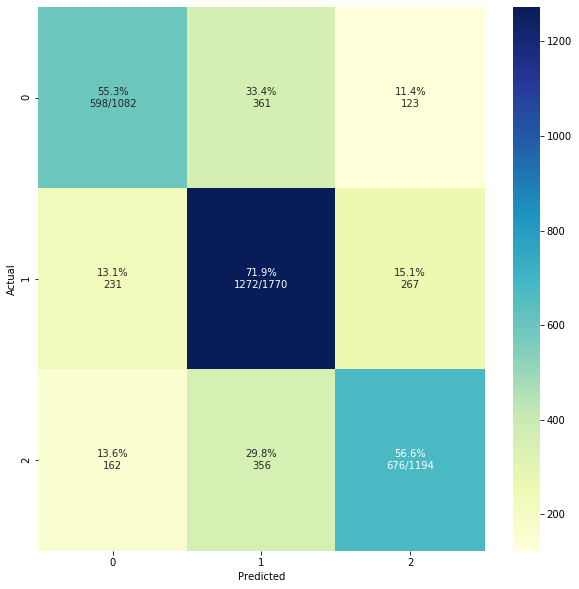

In [37]:
#Lets look at prediction accuracy for each target class
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

plot_cm (y_test, predicted)

In [38]:
# Deep Learning Model : Recurrent Neural Networks with LSTM cells

inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size, 200, input_length=MAX_LENGTH)(inputs)

x = LSTM(72)(embedding_layer)
x = Dense(64, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

filepath="weights.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.20, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 302)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 302, 200)          6658600   
_________________________________________________________________
lstm (LSTM)                  (None, 72)                78624     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4672      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 6,742,091
Trainable params: 6,742,091
Non-trainable params: 0
_________________________________________________________________
Train on 12945 samples, validate on 3237 samples
Epoch 1/5
12928/12945 [============================>.] - ETA: 0s -

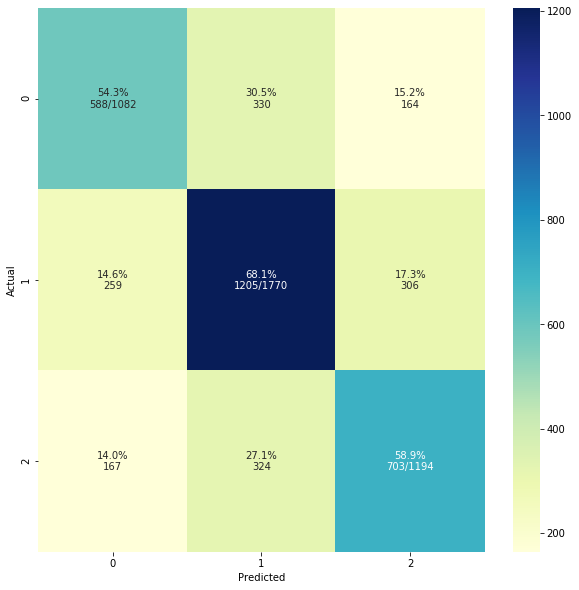

In [39]:
#Lets look at prediction accuracy for each target class
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

plot_cm (y_test, predicted)

##### Final Observations

1. By far the model with RNN with LSTM cells performs best compared to all the other models built
2. The overall accuracy on validation dataset is 65% and the three target varibale classes (Negetive, Neutral and Positive) have accuracy of 58.1%, 70.7% and 55.8% respectively
3. We may be able to improve this model marginally by playing with hyper-parameters like number of layers, number of LSTM cells, changing the optimizers etc.But looking at results of alll the models, it does not seem the improvment would be substantial
4. We can also try combination of CNN and RNN with atention models to improve the results, but those will be more complex models 
5. We have to think of ways in which we can improve the input data quality to improve the prediction accuracy


##### How to improve

####### Strategy 1
1. The best way is to cluster the reviews with topic modeling algorithms and manually correct the sentiment
2. For this we would need a person well versed with the language (Urdu and Roman in this case)
3. We run the topic modeling, then read the top 10 and bottom 10 reviews in each topic cluster and then label the customer with proper sentiment

####### Strategy 2
1. All the models tried here use words in the reviews and tries to separate and classsify sentiment andd the main reason the accuracy is not improving is that there are a lot of common words in each sentiment classes
2. We can further analyze the frequest words common in all 3 setiment classes and also common words between each of the 2 selected classes and remoce them
3. This process does not need a language expert and is quicker also
